<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-statistics" data-toc-modified-id="Task-statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task statistics</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train model</a></span><ul class="toc-item"><li><span><a href="#Evaluate-performance" data-toc-modified-id="Evaluate-performance-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Evaluate performance</a></span></li></ul></li><li><span><a href="#Ratemaps" data-toc-modified-id="Ratemaps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ratemaps</a></span><ul class="toc-item"><li><span><a href="#Grid-scores" data-toc-modified-id="Grid-scores-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Grid scores</a></span></li></ul></li><li><span><a href="#Manifold-distance" data-toc-modified-id="Manifold-distance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Manifold distance</a></span></li><li><span><a href="#Neural-sheet" data-toc-modified-id="Neural-sheet-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Neural sheet</a></span></li><li><span><a href="#Connectivity" data-toc-modified-id="Connectivity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Connectivity</a></span><ul class="toc-item"><li><span><a href="#Sort-weights" data-toc-modified-id="Sort-weights-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Sort weights</a></span></li></ul></li><li><span><a href="#Path-integration" data-toc-modified-id="Path-integration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Path integration</a></span></li><li><span><a href="#SVD" data-toc-modified-id="SVD-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SVD</a></span></li><li><span><a href="#Null-model-(low-pass-filtered-noise)" data-toc-modified-id="Null-model-(low-pass-filtered-noise)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Null model (low-pass filtered noise)</a></span></li><li><span><a href="#Boundary-extension" data-toc-modified-id="Boundary-extension-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Boundary extension</a></span></li><li><span><a href="#Head-direction-and-speed-tuning" data-toc-modified-id="Head-direction-and-speed-tuning-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Head direction and speed tuning</a></span></li><li><span><a href="#Border-score" data-toc-modified-id="Border-score-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Border score</a></span></li></ul></div>

In [55]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [57]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN
from trainer import Trainer

In [58]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = '/home/yuling/grid-pattern-formation/models'
options.n_steps = 100000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves # ?
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

options.run_ID = generate_run_ID(options)
options.device = 'cpu'

In [59]:
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
model = RNN(options, place_cells) #.cuda()
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

Initializing new model from scratch.
Saving to: /home/yuling/grid-pattern-formation/models/steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001


In [60]:
# Load example weights stored on github
weight_dir = options.save_dir + '/example_trained_weights.npy'
load_trained_weights(model, trainer, weight_dir)

Epoch: 0/1. Step 0/1. Loss: 6.37. Err: 98.05cm
Loaded trained weights.


# Task statistics

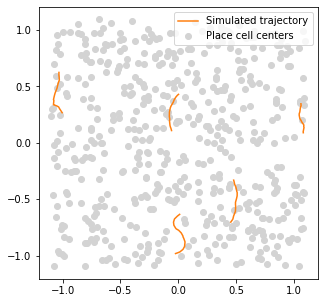

In [61]:
# Plot a few sample trajectories
inputs, pos, pc_outputs, _ = trajectory_generator.get_test_batch()
us = place_cells.us.cpu()
pos = pos.cpu()

plt.figure(figsize=(5,5))
plt.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')
for i in range(5):
    plt.plot(pos[:,i,0],pos[:,i,1], label='Simulated trajectory', c='C1')
    if i==0:
        plt.legend();

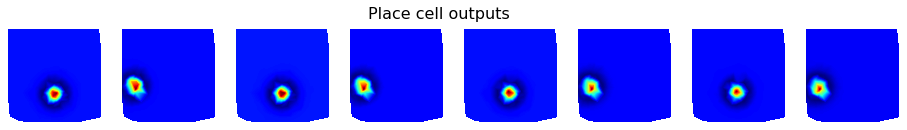

In [62]:
# Plot a few place cell outputs
pc_outputs = pc_outputs.reshape(-1, options.Np).detach().cpu()
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# plt.tight_layout()

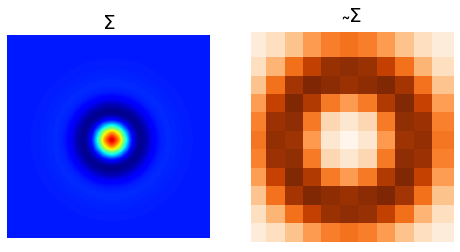

In [63]:
# Visualize place cell covariance matrix
Cmean = place_cells.compute_covariance(res=30)

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(Cmean, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs],
            s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

# Train model

In [64]:
# trainer.train(n_steps=options.n_steps, save=True)

# plt.figure(figsize=(12,3))
# plt.subplot(121)
# plt.plot(trainer.err, c='black')

# plt.title('Decoding error (m)'); plt.xlabel('train step')
# plt.subplot(122)
# plt.plot(trainer.loss, c='black');
# plt.title('Loss'); plt.xlabel('train step');

## Evaluate performance

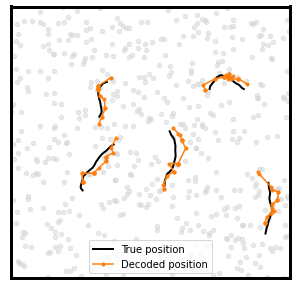

In [65]:
inputs, pos, pc_outputs, _ = trajectory_generator.get_test_batch()
pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs)).cpu()
us = place_cells.us.cpu()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[:,i,0], pos[:,i,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    if i==0:
        plt.legend()
plt.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2]);
# plt.savefig('images/sim_traj_decode.pdf')

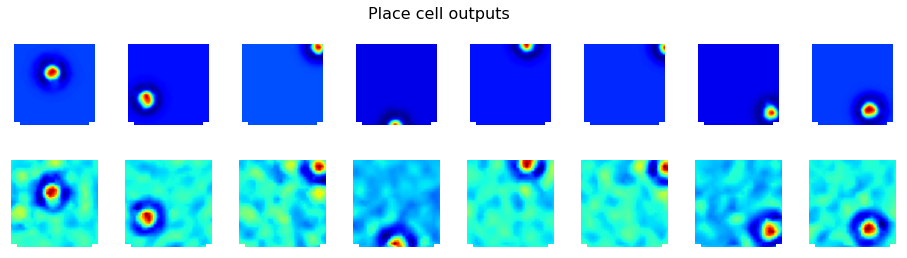

In [67]:
# Visualize predicted place cell outputs
inputs, pos, pc_outputs, _ = trajectory_generator.get_test_batch()
preds = model.predict(inputs)
preds = preds.reshape(-1, options.Np).detach().cpu()
pc_outputs = model.softmax(pc_outputs).reshape(-1, options.Np).cpu()
pc_pred = place_cells.grid_pc(preds[:100])
pc = place_cells.grid_pc(pc_outputs[:100])

plt.figure(figsize=(16,4))
for i in range(8):
    plt.subplot(2,8,i+9)
    plt.imshow(pc_pred[2*i], cmap='jet')
    if i==0:
        plt.ylabel('Predicted')
    plt.axis('off')
    
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(pc[2*i], cmap='jet', interpolation='gaussian')
    if i==0:
        plt.ylabel('True')
    plt.axis('off')
    
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# Ratemaps

In [114]:
from visualize import compute_ratemaps, plot_ratemaps
res = 50
n_avg = 100
Ng = options.Ng
activations, rate_map, g, pos, activations_theta = compute_ratemaps(model,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=Ng)

# Compute a set of lo-res maps to use for evalutaing grid score
# lo_res = 20 # low resolution
# _, rate_map_lores, _, _ = compute_ratemaps(model,
#                                          trajectory_generator,
#                                          options,
#                                          res=lo_res,
#                                          n_avg=n_avg,
#                                          Ng=Ng)
# n_plot = 256
# plt.figure(figsize=(16,4*n_plot//8**2))
# rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
# plt.imshow(rm_fig)
# plt.axis('off');

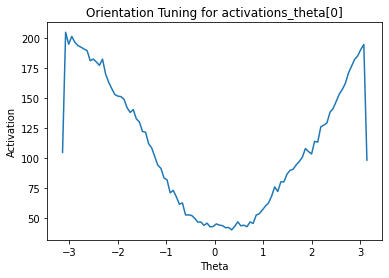

In [117]:
# 绘制orientation tuning
theta = np.linspace(-np.pi, np.pi, res*2)
i = 0
plt.figure()
plt.plot(theta, activations_theta[i])
plt.title(f'Orientation Tuning for activations_theta[{i}]')
plt.xlabel('Theta')
plt.ylabel('Activation')
plt.show()

In [122]:
# np.save('rate_map.npy', rate_map)
np.save('activations_theta.npy', activations_theta)

# Band scores final

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as nf
from scipy.optimize import curve_fit

def band_score(rate,res):
    X,Y = np.meshgrid(np.linspace(-2,2,res),np.linspace(-2,2,res))
    x_flat,y_flat = X.flatten(), Y.flatten()
    loc = np.stack([x_flat,y_flat])
    def spectrum(ratemap):
        res = ratemap.shape[0]
        fft_rate = np.abs(nf.fftshift(nf.fft2(ratemap)))
        fft_rate[:int(res/2),:] = 0
        return fft_rate
    ratemap = rate.reshape(res,res)
    fft_rate = spectrum(ratemap)

    # 定义高斯函数
    def gaussian(loc, A, k, phi, sigma):
        x = loc[0]
        y = loc[1]
        return A * np.exp(-((x - k*np.cos(phi))**2 / (2 * sigma**2) + (y - k*np.sin(phi))**2 / (2 * sigma**2)))

    initial_guess = [1.0, 0.2, 0.0, 0.1]

    try:
        params, _ = curve_fit(lambda xy, A, k, phi, sigma: gaussian(xy, A, k, phi, sigma), 
                                (loc), 
                                fft_rate.ravel(), 
                                p0=initial_guess, 
                                bounds=([0, 0.2, 0, 0.05], [np.inf, 1, np.pi, 0.5]),
                                maxfev=1000)  # 增加最大函数评估次数
    except RuntimeError as e:
        # print("Warning:", e)
        # 使用 `full_output=True` 调用 leastsq 获取最后一步的参数
        from scipy.optimize import leastsq
        params, _, _, _, _ = leastsq(
            lambda xy: fft_rate.ravel() - gaussian(loc, *xy), initial_guess or np.ones(len(initial_guess)), full_output=True, maxfev=1000
        )
        # print("Returning last known parameters:", params)
    # return popt, pcov
    dx = 4.4/res
    k0 = params[1]
    phi = params[2]
    sigma = params[3]
    kx = k0*np.cos(phi)/2*(1/dx/2)*np.pi*2
    ky = k0*np.sin(phi)/2*(1/dx/2)*np.pi*2
    k = np.sqrt(kx**2+ky**2)# The maximum frequency is 1/dx, correspoding k = np.pi*2/dx
    # print(params)
    gx = gaussian(loc, params[0], params[1], params[2], params[3])

    # 计算相关性
    band_scores = np.dot(fft_rate.ravel(), gx.ravel()) / (1e-8+np.linalg.norm(fft_rate.ravel()) * np.linalg.norm(gx.ravel())) / sigma

    return band_scores, ratemap, params, fft_rate, gx, k, phi, sigma


In [119]:
from tqdm import tqdm
import numpy as np

res = 50

data = np.load('rate_map.npy')
print(data.shape)
Ng = data.shape[0]
T = data.shape[1]
score = np.zeros(Ng,)
k = np.zeros(Ng,)
phi = np.zeros(Ng,)
sigma = np.zeros(Ng,)
ratemap = np.zeros([Ng,50,50])
for i in tqdm(range(Ng)):
    rate = data[i]-np.mean(data[i])
    band_scores, rm, params, fft_rate, gx, k[i], phi[i], sigma[i] = band_score(rate,res)
    ratemap[i] = rm
    score[i] = band_scores

  0%|          | 8/4096 [00:00<00:56, 72.63it/s]

(4096, 2500)


100%|██████████| 4096/4096 [00:51<00:00, 79.75it/s]


Text(0.5, 1.0, 'band score distribution')

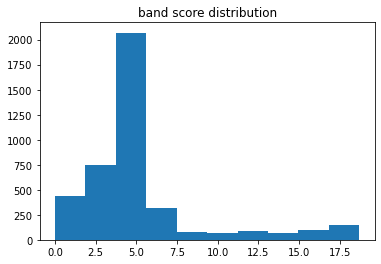

In [121]:
plt.hist(score)
plt.title('band score distribution')

selected cell number: 505


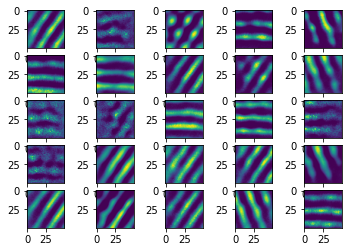

In [ ]:
# 绘制place tuning
score_thres = 8.0

index = np.argsort(-score)
n_sub = 5
fig,ax = plt.subplots(n_sub,n_sub)
# print(score[index[800]])
index_band = np.where(score>score_thres)[0]
# index_band = np.
print('selected cell number:',index_band.shape[0])

# print(len(index_band))
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x,y].imshow(ratemap[index_band[i]])
    

selected cell number: 505


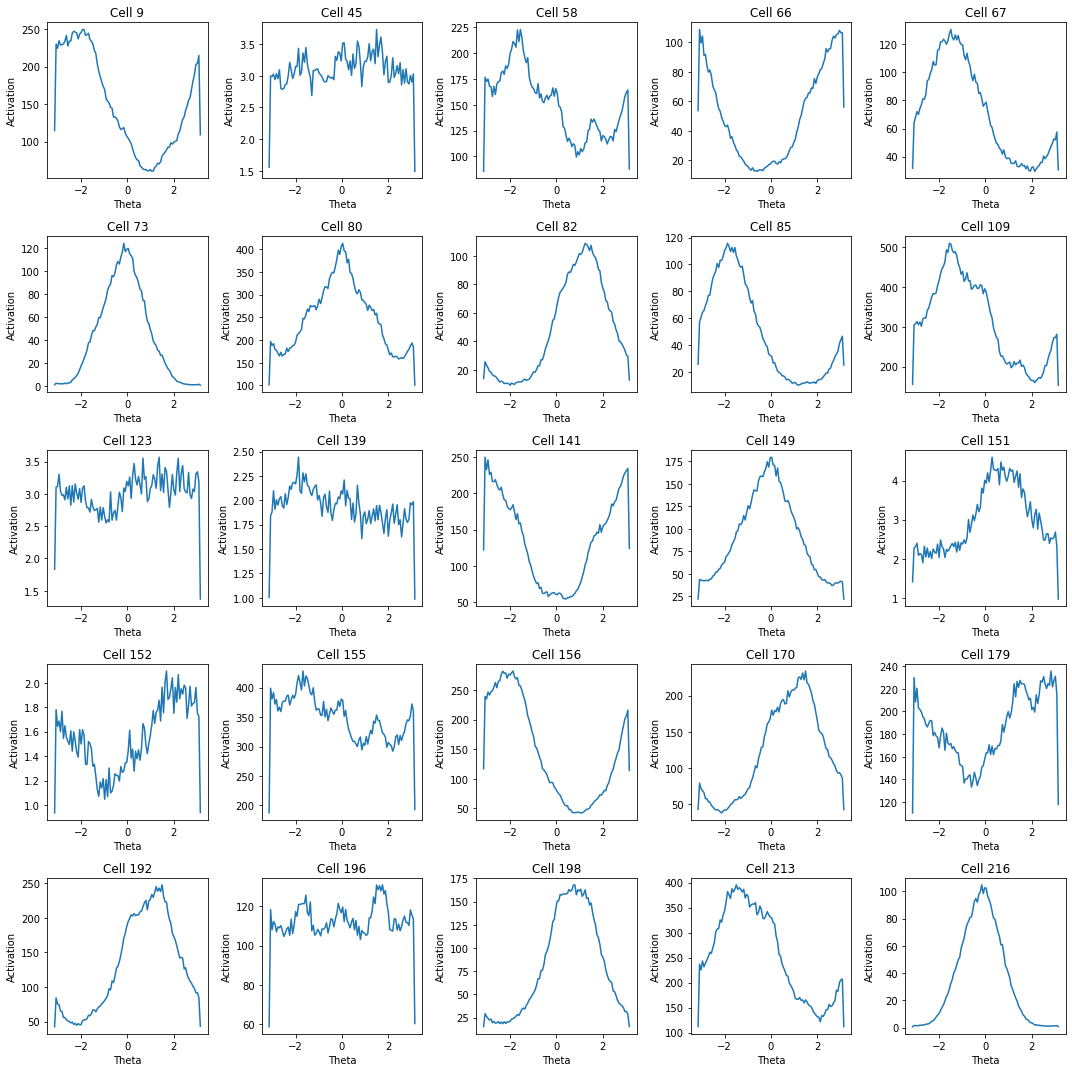

In [ ]:
# 绘制orientation tuning
score_thres = 8.0

index = np.argsort(-score)
n_sub = 5
fig, ax = plt.subplots(n_sub, n_sub, figsize=(15, 15))
index_band = np.where(score > score_thres)[0]
print('selected cell number:', index_band.shape[0])

theta = np.linspace(-np.pi, np.pi, res * 2)
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x, y].plot(theta, activations_theta[index_band[i]])
    ax[x, y].set_title(f'Cell {index_band[i]}')
    ax[x, y].set_xlabel('Theta')
    ax[x, y].set_ylabel('Activation')

plt.tight_layout()
plt.show()

[1.74829746 1.76       1.76       ... 1.34128561 1.31073342 1.40912678]
(505,)


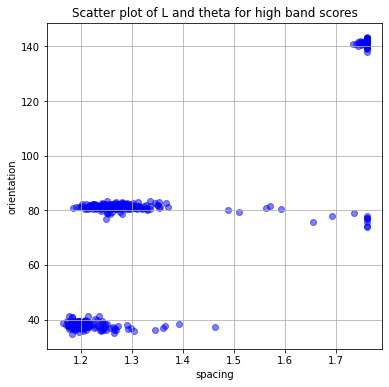

In [7]:
# 周期和朝向
L = 2*np.pi / k
print(L)

## 绘制 k_mag_opts 和 theta_opts 的散点图
plt.figure(figsize=(6, 6))
high_band_idxs = np.where(score > score_thres)[0]
print(high_band_idxs.shape)
plt.scatter(L[high_band_idxs], phi[high_band_idxs]/np.pi*180, c='blue', alpha=0.5)
plt.xlabel('spacing')
plt.ylabel('orientation')
plt.title('Scatter plot of L and theta for high band scores')
plt.grid(True)
plt.show()

(array([149., 159.,  52.,  12.,   0.,   3.,   2.,   1.,   2., 125.]),
 array([1.16452129, 1.22406916, 1.28361703, 1.3431649 , 1.40271277,
        1.46226065, 1.52180852, 1.58135639, 1.64090426, 1.70045213,
        1.76      ]),
 <BarContainer object of 10 artists>)

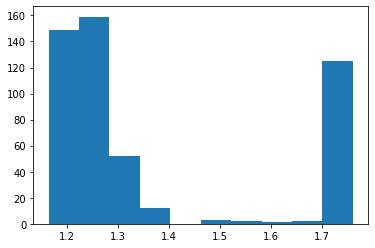

In [8]:
plt.hist(L[index_band])
# print(score)

(array([163.,   0.,   0.,  10., 215.,   0.,   0.,   0.,   0., 117.]),
 array([ 34.73715347,  45.587396  ,  56.43763852,  67.28788105,
         78.13812358,  88.9883661 ,  99.83860863, 110.68885116,
        121.53909368, 132.38933621, 143.23957874]),
 <BarContainer object of 10 artists>)

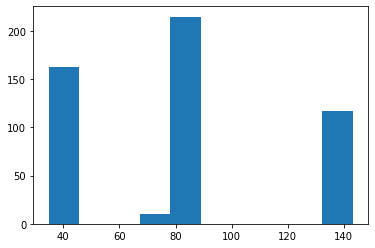

In [9]:
plt.hist(phi[index_band]/np.pi*180)

In [54]:
# 计算相位 fai
N_band = k.shape[0]
phase = np.zeros(N_band)  # 使用复数类型
# "loc" here is different from what we use in "band score", it's the real physical location
X,Y = np.meshgrid(np.linspace(-2.2,2.2,res),np.linspace(-2.2,2.2,res))
x_flat,y_flat = X.flatten(), Y.flatten()
loc = np.stack([x_flat,y_flat])

for i in range(high_band_idxs.shape[0]):
    j = 1j  # 虚部
    k_vec = np.array([k[high_band_idxs[i]]*np.cos(phi[high_band_idxs[i]]),k[high_band_idxs[i]]*np.sin(phi[high_band_idxs[i]])]).reshape(1,2) #1*2
    loc_phase = np.mod(np.dot(k_vec,loc), L[high_band_idxs[i]])/L[high_band_idxs[i]]*np.pi*2-np.pi #1*Ng
    phase[high_band_idxs[i]] = np.angle(np.sum(np.exp(loc_phase*1j)*rate)/np.sum(rate)) # 1

# print(phase)
# 

(array([ 13.,  21.,  29.,  15.,  27.,  40., 173., 121.,  40.,  26.]),
 array([-3.12115926, -2.495197  , -1.86923473, -1.24327247, -0.61731021,
         0.00865205,  0.63461431,  1.26057657,  1.88653883,  2.51250109,
         3.13846335]),
 <BarContainer object of 10 artists>)

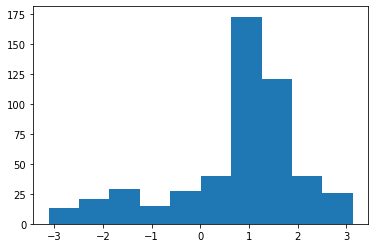

In [11]:
plt.hist(phase[high_band_idxs].reshape(-1,))

In [12]:
# 提取四个网络
high_band_idxs = np.where(score > score_thres)[0]

L_low_theta_low = np.where((L > 0) & (L < 1.4) & (phi/np.pi*180 > 0) & (phi/np.pi*180 < 60))[0]
L_low_theta_mid= np.where((L > 0) & (L < 1.4) & (phi/np.pi*180 > 60) & (phi/np.pi*180 < 100))[0]
L_high_theta_mid = np.where((L > 1.7) & (phi/np.pi*180 > 60) & (phi/np.pi*180 < 100))[0]
L_high_theta_high = np.where((L > 1.7) & (phi/np.pi*180 > 120))[0]

# 和high_band_idxs取交集
L_low_theta_low = np.intersect1d(L_low_theta_low, high_band_idxs)
L_low_theta_mid = np.intersect1d(L_low_theta_mid, high_band_idxs)
L_high_theta_mid = np.intersect1d(L_high_theta_mid, high_band_idxs)
L_high_theta_high = np.intersect1d(L_high_theta_high, high_band_idxs)

In [ ]:
# 连接权重矩阵
J = model.RNN.weight_hh_l0.data.numpy()

# 四个网络的连接权重矩阵
L_low_theta_low_idxs = L_low_theta_low[np.argsort(phase[L_low_theta_low])]
L_low_theta_mid_idxs = L_low_theta_mid[np.argsort(phase[L_low_theta_mid])]
L_high_theta_mid_idxs = L_high_theta_mid[np.argsort(phase[L_high_theta_mid])]
L_high_theta_high_idxs = L_high_theta_high[np.argsort(phase[L_high_theta_high])]

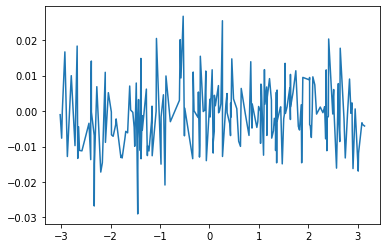

In [81]:
index_study = L_low_theta_mid_idxs
phases_study = phase[index_study]
weights = J[index_study][:, index_study]
index_neuron = 101
plt.plot(phases_study,weights[index_neuron,:])
# plt.hist(weights.flatten())

In [94]:
np.sum(weights[index_neuron, :])

-0.23886378

In [95]:
np.sum(weights[0,:])

-0.09306048

(210,)


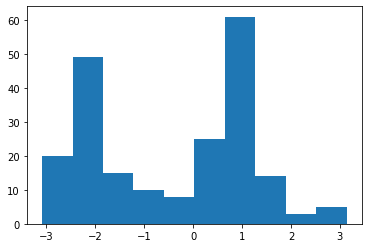

In [ ]:

N_study = phases_study.shape[0]
phase_bias = np.zeros(N_study) 
for i in range(N_study):
    phase_bias[i] = np.angle(np.sum(np.exp(phases_study*1j)*weights[i,:])/np.sum(weights[index_neuron,:])) #index_neuron是怎么选的

plt.hist(phase_bias)
print(phase_bias.shape)

/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/home/yuling/miniconda3/envs/gridRNN/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


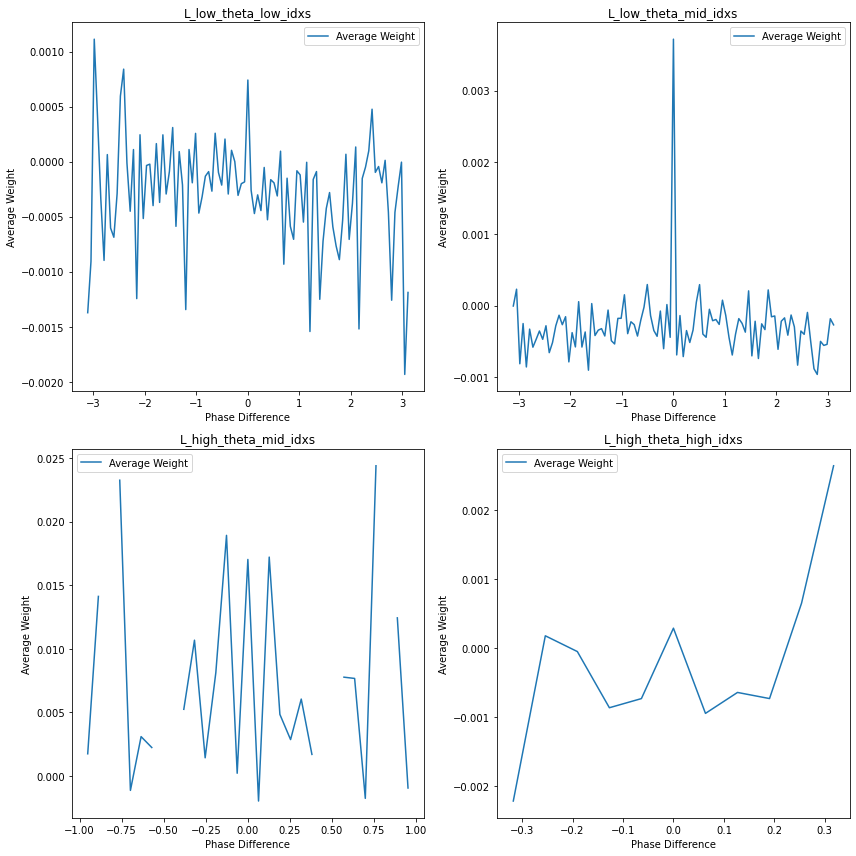

In [ ]:
# Calculate phase differences
def phase_difference(phases):
    phase_diff = np.angle(np.exp(1j * (phases[:, None] - phases[None, :])))
    return phase_diff

# Calculate average weights as a function of phase difference
def average_weights_vs_phase_diff(idxs):
    phases = phase[idxs]
    weights = J[idxs][:, idxs]
    phase_diff = phase_difference(phases)
    
    # Flatten the arrays
    phase_diff_flat = phase_diff.flatten()
    weights_flat = weights.flatten()
    
    # # Filter weights to include only those greater than 0
    # positive_weights_mask = weights_flat > 0
    # phase_diff_flat = phase_diff_flat[positive_weights_mask]
    # weights_flat = weights_flat[positive_weights_mask]
    
    # Bin the phase differences
    bins = np.linspace(-np.pi, np.pi, 100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    digitized = np.digitize(phase_diff_flat, bins) - 1
    
    # Calculate the average weight for each bin
    avg_weights = np.array([weights_flat[digitized == i].mean() for i in range(len(bin_centers))])
    
    return bin_centers, avg_weights

# Plot average weights as a function of phase difference
def plot_average_weights_vs_phase_diff(ax, idxs, title):
    bin_centers, avg_weights = average_weights_vs_phase_diff(idxs)
    ax.plot(bin_centers, avg_weights, label='Average Weight')
    ax.set_title(title)
    ax.set_xlabel('Phase Difference')
    ax.set_ylabel('Average Weight')
    ax.set_facecolor('white')  # Set background color to white
    ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot L_low_theta_low_idxs
plot_average_weights_vs_phase_diff(axs[0, 0], L_low_theta_low_idxs, 'L_low_theta_low_idxs')

# Plot L_low_theta_mid_idxs
plot_average_weights_vs_phase_diff(axs[0, 1], L_low_theta_mid_idxs, 'L_low_theta_mid_idxs')

# Plot L_high_theta_mid_idxs
plot_average_weights_vs_phase_diff(axs[1, 0], L_high_theta_mid_idxs, 'L_high_theta_mid_idxs')

# Plot L_high_theta_high_idxs
plot_average_weights_vs_phase_diff(axs[1, 1], L_high_theta_high_idxs, 'L_high_theta_high_idxs')

plt.tight_layout()
plt.show()

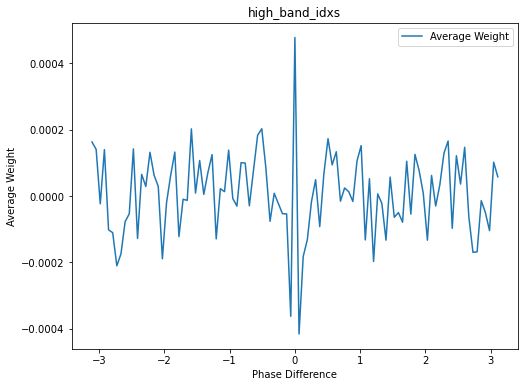

In [179]:
# 四个网络的叠加
high_band_idxs = np.where(score > score_thres)[0]

# high_band_idxs
fig, ax = plt.subplots(figsize=(8, 6))
plot_average_weights_vs_phase_diff(ax, high_band_idxs, 'high_band_idxs')
plt.show()

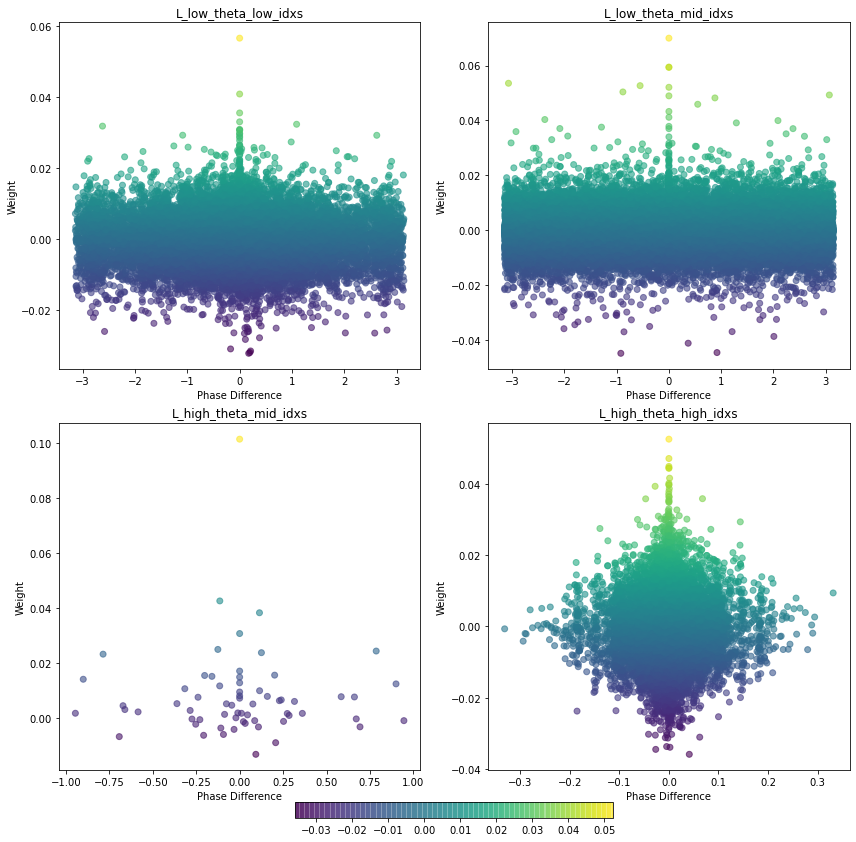

In [171]:
# Calculate phase differences
def phase_difference(phases):
    phase_diff = np.angle(np.exp(1j * (phases[:, None] - phases[None, :])))
    return phase_diff

# Plot weights as a function of phase difference
def plot_weights_vs_phase_diff(ax, idxs, title):
    phases = phase[idxs]
    weights = J[idxs][:, idxs]
    phase_diff = phase_difference(phases)
    
    sc = ax.scatter(phase_diff.flatten(), weights.flatten(), c=weights.flatten(), cmap='viridis', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Phase Difference')
    ax.set_ylabel('Weight')
    ax.set_facecolor('white')  # Set background color to white
    return sc

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot L_low_theta_low_idxs
sc = plot_weights_vs_phase_diff(axs[0, 0], L_low_theta_low_idxs, 'L_low_theta_low_idxs')

# Plot L_low_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[0, 1], L_low_theta_mid_idxs, 'L_low_theta_mid_idxs')

# Plot L_high_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[1, 0], L_high_theta_mid_idxs, 'L_high_theta_mid_idxs')

# Plot L_high_theta_high_idxs
sc = plot_weights_vs_phase_diff(axs[1, 1], L_high_theta_high_idxs, 'L_high_theta_high_idxs')

plt.tight_layout()
fig.colorbar(sc, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()

# Band scores


In [ ]:
#============拟合平面波函数============
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# 定义平面波函数
def plane_wave(x, y, A, k_mag, theta):
    kx = k_mag * np.cos(theta)
    ky = k_mag * np.sin(theta)
    return A * (np.cos(kx * x + ky * y) + 1)

res = 50
# 提取rate_map中的位置响应
x = np.linspace(-options.box_width / 2, options.box_width / 2, res)
y = np.linspace(-options.box_height / 2, options.box_height / 2, res)
x, y = np.meshgrid(x, y)

# 关于位置响应的activations heatmap展平得到rate_map
f_x = rate_map

# 展平 x 和 y 网格
x_flat = x.ravel()
y_flat = y.ravel()

# 初始参数猜测
initial_guess = [1.0, 1.0, 1.0]

# 存储所有 band scores 和优化参数
band_scores_1 = []
A_opts = []
k_mag_opts = []
theta_opts = []
g_x = []

# 对每一个 f_x 进行拟合
for i in range(f_x.shape[0]):
    if np.all(f_x[i] == 0):
        band_scores_1.append(0)
        A_opts.append(np.nan)
        k_mag_opts.append(np.nan)
        theta_opts.append(np.nan)
        continue
    
    # 优化参数A, k_mag, theta
    try:
        params, _ = curve_fit(lambda xy, A, k_mag, theta: plane_wave(xy[0], xy[1], A, k_mag, theta).ravel(), 
                              (x_flat, y_flat), 
                              f_x[i].ravel(), 
                              p0=initial_guess, 
                              bounds=([0, 1, -np.pi], [np.inf, np.inf, np.pi]),
                              maxfev=10000)  # 增加最大函数评估次数

        # 提取优化后的参数
        A_opt, k_mag_opt, theta_opt = params
        A_opts.append(A_opt)
        k_mag_opts.append(k_mag_opt)
        theta_opts.append(theta_opt)

        # 计算拟合后的g(x; A, k)
        g_x_ = plane_wave(x, y, A_opt, k_mag_opt, theta_opt)
        g_x.append(g_x_)

        # 计算相关性
        band_score = np.dot(f_x[i].ravel(), g_x_.ravel()) / (np.linalg.norm(f_x[i].ravel()) * np.linalg.norm(g_x_.ravel()))
        band_scores_1.append(band_score)
    except RuntimeError as e:
        print(f"Optimal parameters not found for sample {i}: {e}")
        band_scores_1.append(0)
        A_opts.append(np.nan)
        k_mag_opts.append(np.nan)
        theta_opts.append(np.nan)

band_scores_1 = np.array(band_scores_1)
A_opts = np.array(A_opts)
k_mag_opts = np.array(k_mag_opts)
theta_opts = np.array(theta_opts)

# 打印 band scores 和优化参数
print("Band scores:", band_scores_1)
print("A_opts:", A_opts)
print("k_mag_opts:", k_mag_opts)
print("theta_opts:", theta_opts)

In [ ]:
# 挑选 band scores 较高的细胞
idxs = np.flip(np.argsort(np.nan_to_num(band_scores_1)))

# Plot high band scores
n_plot = 100
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('High Band scores '+str(np.round(band_scores_1[idxs[0]], 2))
             +' -- '+ str(np.round(band_scores_1[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

In [ ]:
#============傅里叶变换 + 拟合高斯函数============
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# 定义高斯函数
def gaussian(x, y, A, x0, y0):
    sigma = 0.068
    return A * np.exp(-((x - x0)**2 / (2 * sigma**2) + (y - y0)**2 / (2 * sigma**2)))

res = 50
# 提取rate_map中的位置响应
x = np.linspace(-options.box_width / 2, options.box_width / 2, res)
y = np.linspace(-options.box_height / 2, options.box_height / 2, res)
x, y = np.meshgrid(x, y)

# 关于位置响应的activations heatmap展平得到rate_map
# Fourier transform 傅里叶转换
Ng = options.Ng
rm_fft = []

# 定义频谱函数
def spectrum(ratemap):
    res = ratemap.shape[0]
    fft_rate = np.abs(np.fft.fftshift(np.fft.fft2(ratemap)))
    fft_rate[:int(res/2),:] = 0
    return fft_rate

# 计算频谱
for i in tqdm(range(Ng)):
    rm_fft_ = spectrum(activations[i])
    rm_fft.append(rm_fft_)

# 展开
f_x_fft = np.array(rm_fft).reshape(Ng, -1)

# 展平 x 和 y 网格
x_flat = x.ravel()
y_flat = y.ravel()

# 初始参数猜测
initial_guess = [1.0, 0.0, 0.0]

# 存储所有 band scores 和优化参数
band_scores_2 = []
A_opts = []
x0_opts = []
y0_opts = []
g_x = []

# 对每一个 f_x_fft 进行拟合
for i in range(f_x_fft.shape[0]):
    if np.all(f_x_fft[i] == 0):
        band_scores_2.append(0)
        A_opts.append(np.nan)
        x0_opts.append(np.nan)
        y0_opts.append(np.nan)
        continue
    
    # 优化参数A, x0, y0, sigma
    try:
        params, _ = curve_fit(lambda xy, A, x0, y0: gaussian(xy[0], xy[1], A, x0, y0).ravel(), 
                              (x_flat, y_flat), 
                              f_x_fft[i].ravel(), 
                              p0=initial_guess, 
                              bounds=([0, -options.box_width / 2, 0], [np.inf, options.box_width / 2, options.box_height]),
                              maxfev=10000)  
                              # 增加最大函数评估次数

        # 提取优化后的参数
        A_opt, x0_opt, y0_opt = params
        A_opts.append(A_opt)
        x0_opts.append(x0_opt)
        y0_opts.append(y0_opt)

        # 计算拟合后的g(x; A, x0, y0)
        g_x_ = gaussian(x, y, A_opt, x0_opt, y0_opt)
        g_x.append(g_x_)

        # 计算相关性
        band_score = np.dot(f_x_fft[i].ravel(), g_x_.ravel()) / (np.linalg.norm(f_x_fft[i].ravel()) * np.linalg.norm(g_x_.ravel()))
        band_scores_2.append(band_score)
    except RuntimeError as e:
        print(f"Optimal parameters not found for sample {i}: {e}")
        band_scores_2.append(0)
        A_opts.append(np.nan)
        x0_opts.append(np.nan)
        y0_opts.append(np.nan)

band_scores_2 = np.array(band_scores_2)
A_opts = np.array(A_opts)
x0_opts = np.array(x0_opts)
y0_opts = np.array(y0_opts)

# 打印 band scores 和优化参数
print("Band scores:", band_scores_2)
print("A_opts:", A_opts)
print("x0_opts:", x0_opts)
print("y0_opts:", y0_opts)

In [ ]:
# 挑选 band scores 较高的细胞
idxs = np.flip(np.argsort(np.nan_to_num(band_scores_2)))

# Plot high band scores
n_plot = 100
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('High Band scores '+str(np.round(band_scores_2[idxs[0]], 2))
             +' -- '+ str(np.round(band_scores_2[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

In [ ]:
# 条件筛选
condition = (np.logical_and(x0_opts >= -0.5, x0_opts <= -0.06)) | (np.logical_and(x0_opts > 0.06, x0_opts <= 0.5))
# condition = (x0_opts >= -0.5) | (x0_opts > 0.06)

# 获取满足条件的索引
filtered_idxs = np.where(condition)[0]

# 获取对应的 band_scores_2 的值
filtered_band_scores_2 = band_scores_2[filtered_idxs]

# 打印结果
print("Filtered indices:", filtered_idxs)
print("Filtered band_scores_2:", filtered_band_scores_2)

# 挑选 band scores 较高的细胞
idxs = np.flip(np.argsort(np.nan_to_num(filtered_band_scores_2)))

# Plot high band scores
n_plot = 100
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('High Band scores '+str(np.round(filtered_band_scores_2[idxs[0]], 2))
             +' -- '+ str(np.round(filtered_band_scores_2[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

In [ ]:
# 可视化结果
plt.figure(figsize=(18, 6))
i = 77
print(x0_opts[i])
plt.subplot(1, 3, 1)
plt.title("f(x)")
plt.imshow(f_x[i].reshape(res, res), cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("f(x) FFT")
plt.imshow(f_x_fft[i].reshape(res, res), cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("g(x; A, k)")
plt.imshow(g_x[i], cmap='viridis')
plt.colorbar()

plt.show()

In [ ]:
# 可视化结果
plt.figure(figsize=(18, 6))
i = 11
print(x0_opts[idxs[i]])
plt.subplot(1, 3, 1)
plt.title("f(x)")
plt.imshow(f_x[idxs[i]].reshape(res, res), cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("f(x) FFT")
plt.imshow(f_x_fft[idxs[i]].reshape(res, res), cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("g(x; A, k)")
plt.imshow(g_x[idxs[i]], cmap='viridis')
plt.colorbar()

plt.show()

In [ ]:
# 挑选 band scores 1 和 2 都较高的细胞
band_scores = band_scores_1 * band_scores_2
idxs = np.flip(np.argsort(np.nan_to_num(band_scores)))

# Plot high band scores
n_plot = 100
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('High Band scores '+str(np.round(band_scores[idxs[0]], 2))
             +' -- '+ str(np.round(band_scores[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

In [ ]:
k = [k_mag_opts * np.cos(theta_opts), k_mag_opts * np.sin(theta_opts)]
print(k)

L = 2*np.pi / np.sqrt(k_mag_opts)
print(L)

In [ ]:
## 绘制 k_mag_opts 和 theta_opts 的散点图
plt.figure(figsize=(10, 6))
high_band_idxs = np.where(band_scores > 0.8)[0]
plt.scatter(L[high_band_idxs], theta_opts[high_band_idxs], c='blue', alpha=0.5)
plt.xlabel('L')
plt.ylabel('theta')
plt.title('Scatter plot of L and theta for high band scores')
plt.grid(True)
plt.show()

In [ ]:
# 计算相位 fai
fai = np.zeros(activations.shape[0], dtype=complex)  # 使用复数类型
for i in range(activations.shape[0]):
    j = 1j  # 虚部
    numerator = np.sum(activations[i] * (np.cos(k[0][i] * x + k[1][i] * y) + np.sin(k[0][i] * x + k[1][i] * y) * j))
    denominator = np.sum(activations[i])
    if denominator != 0:
        fai[i] = numerator / denominator
    else:
        fai[i] = 0

In [ ]:
# 挑选 band scores 最高的 100 个神经元
top_100_indices = idxs[:100]

# 根据 fai 对这些神经元进行排序
sorted_indices = top_100_indices[np.argsort(np.angle(fai[top_100_indices]))]

# 连接权重矩阵
J = model.RNN.weight_hh_l0.data.numpy()

# 绘制连接权重
plt.figure(figsize=(10, 10))
plt.imshow(J[sorted_indices][:, sorted_indices], cmap='viridis')
plt.colorbar()
plt.title('Connection Weights of Top 1000 Neurons Sorted by Phase')
plt.show()

In [ ]:
# 绘制相位分布
plt.figure(figsize=(10, 6))
plt.hist(np.angle(fai[sorted_indices]), bins=30, color='blue', alpha=0.7)
plt.xlabel('Phase Angle (radians)')
plt.ylabel('Frequency')
plt.title('Distribution of Phase Angles')
plt.grid(True)
plt.show()

## Grid scores

In [ ]:
res = 20

In [ ]:
from scores import GridScorer

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width=options.box_width
box_height=options.box_height
coord_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)

In [ ]:
# 60：旋转了 60 度后计算得到的网格评分。用于评估网格细胞在六边形网格模式中的表现。
# 90：旋转了 90 度后计算得到的网格评分。用于评估网格细胞在正边形网格模式中的表现。
score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
      *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map_lores)])

In [ ]:
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[0]], 2))
             +' -- '+ str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot medium grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs[Ng//4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[Ng//2]], 2))
             +' -- ' + str(np.round(score_60[idxs[Ng//2+n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot low grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[-n_plot]], 2))
             +' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off');

In [ ]:
plt.hist(score_60, range=(-1,2.5), bins=15);
plt.xlabel('Grid score')
plt.ylabel('Count');

# Manifold distance

In [ ]:
res = 50

In [ ]:
# Keeping all grid cells
origins = np.stack(np.mgrid[:3,:3] - 1) * res//4 + res//2

fig = plt.figure(figsize=(8,8))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        origin=np.random.randint(0,100,2)
        origin_idx = np.ravel_multi_index((origins[0,i,j],origins[1,i,j]), (res,res))
        r0 = rate_map[:,origin_idx,None]
        dists = np.linalg.norm(r0 - rate_map, axis=0)
        im = plt.imshow(dists.reshape(res,res)/np.max(dists),
                        cmap='viridis_r', interpolation='gaussian')
        plt.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.74])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.locator_params(nbins=3)
cbar.ax.tick_params(labelsize=20) 
cbar.outline.set_visible(False)

In [ ]:
# Keeping only top 500 grid cells
n_grid_cells = 500
grid_sort = np.flip(np.argsort(score_60))
origins = np.stack(np.mgrid[:3,:3] - 1) * res//4 + res//2

fig = plt.figure(figsize=(8,8))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        origin=np.random.randint(0,100,2)
        origin_idx = np.ravel_multi_index((origins[0,i,j],origins[1,i,j]), (res,res))
        r0 = rate_map[grid_sort[:n_grid_cells],origin_idx,None]
        dists = np.linalg.norm(r0 - rate_map[grid_sort[:n_grid_cells]], axis=0)
        im = plt.imshow(dists.reshape(res,res)/np.max(dists),
                        cmap='viridis_r', interpolation='gaussian')
        plt.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.74])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.locator_params(nbins=3)
cbar.ax.tick_params(labelsize=20) 
cbar.outline.set_visible(False)

# Neural sheet

In [ ]:
# Fourier transform 傅里叶转换
Ng = options.Ng
rm_fft_real = np.zeros([Ng,res,res])
rm_fft_imag = np.zeros([Ng,res,res])

for i in tqdm(range(Ng)):
    rm_fft_real[i] = np.real(np.fft.fft2(rate_map[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(rate_map[i].reshape([res,res])))
    
rm_fft = rm_fft_real + 1j * rm_fft_imag

In [ ]:
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
im = (np.real(rm_fft)**2).mean(0)
im[0,0] = 0
plt.scatter(x2,y2,c=im[idxs][:,idxs], s=300, cmap='Oranges')
plt.axis('equal')
plt.axis('off');
plt.title('Mean power');

In [ ]:
k1 = [3,0]
k2 = [2,3]
k3 = [-1,3]
k4=k5=k6=k1

freq = 1
ks = freq*np.array([k1,k2,k3,k4,k5,k6])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])

In [ ]:
# Find phases
phases = [np.angle(mode) for mode in modes]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phases[0], phases[1], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phases[1], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phases[0], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(phases[0], phases[1], phases[2], c='black', s=2)
ax.view_init(azim=60)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_zlabel(r'$\phi_3$')

In [ ]:
freq = 1
crop = 0
cmaps = ['Blues', 'Oranges', 'Greens']
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@rate_map
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20)
    plt.axis('off')

In [ ]:
from utils import get_2d_sort
import scipy

In [ ]:
N = rate_map.shape[0]
n = int(np.sqrt(N))
width = int(np.sqrt(N))
freq = 1
X,Y = np.meshgrid(np.arange(width),np.arange(width))
X = X*2*np.pi/width
Y = Y*2*np.pi/width

s1 = np.zeros(phases[0].shape)
s2 = np.zeros(phases[0].shape)

fac = np.sqrt(3)/2

for i in range(Ng):
    penalty_1 = np.cos(freq*X - phases[0][i]/fac)
    penalty_2 = np.cos(freq*Y - phases[2][i]/fac)
    penalty_3 = np.cos(freq*(X+Y) - phases[1][i]/fac)
    ind = np.argmax(penalty_1+penalty_2 + penalty_3  + np.random.randn()/100)
    s1[i],s2[i] = np.unravel_index([ind],penalty_1.shape)
    
total_order = get_2d_sort(s1,s2)
rm_sort_square = rate_map[total_order.ravel()].reshape([n,n,-1])

In [ ]:
# Skew matrix to transform parallelogram unit cells to squares 将平行四边形单元格转换为正方形的倾斜矩阵
A = np.asarray([[2,1],[0, np.sqrt(3)]])/4
Ainv = np.linalg.inv(A)

freq = 2
nplots=10
fig, axes = plt.subplots(nplots,nplots, figsize=(16,16))
for i in range(nplots):
    for j in range(nplots):
        idx = np.ravel_multi_index(((i+nplots//2)*res//nplots//freq,
                                    (j+nplots//2)*res//nplots//freq), (res,res))
        im = rm_sort_square[:,:,idx]
        im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
        im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
        axes[j,i].imshow(im.T, cmap='jet')
        axes[j,i].axis('off')

# Connectivity

In [ ]:
# J = model.RNN.weights[1].numpy().T
J = model.RNN.weight_hh_l0.data.numpy()
plt.figure(figsize=(6,6))
plt.imshow(J, cmap='RdBu');
plt.title('J');

In [ ]:
# Eigenvalues 特征值
eigs, eigvs = np.linalg.eig(J) # 特征值，特征向量

fig, ax = plt.subplots()
plt.scatter(np.real(eigs), np.imag(eigs), c='black', s=20)
plt.scatter(np.real(eigs[:9]), np.imag(eigs[:9]), c='C1', s=20)
circle1 = plt.Circle((0, 0), 1, color='tan',
                     fill=False, linestyle='dashed', linewidth=2)
ax.add_artist(circle1)
plt.xlim([-1.1,2.5])
plt.ylim([-1.1,1.1])
plt.gca().set_aspect('equal', adjustable='box')
plt.locator_params(nbins=4)
# plt.axis('equal')
# sns.despine()
# plt.savefig('images/final_eigs.pdf')

In [ ]:
U,S,V = np.linalg.svd(J) # 奇异值分解：左奇异向量，奇异值，右奇异向量

plt.figure(figsize=(8,4))
plt.plot(S[:100], 'o-', c='black')
plt.plot(S[:9], 'o-', c='C1')
# sns.despine();

In [ ]:
# Define eigvs_rot
eigvs_rot = np.real(eigvs)

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A) # 求逆矩阵

plt.figure(figsize=(12,8))
idxs = [1,3,5,4,0,2]
for i in range(6):
    plt.subplot(2,3,i+1)
    im = eigvs_rot[idxs[i]].reshape(n,n)
    im = np.roll(np.roll(im, n//4, axis=1), -n//4, axis=0)
    im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap') # 仿射变换
    if i==1 or i==4:
        im = np.roll(im, -n//3, axis=0)
    im = scipy.ndimage.gaussian_filter(im, sigma=(2,2))
    
    plt.imshow(im, cmap='coolwarm')
    plt.axis('off')
plt.tight_layout()
# plt.savefig('images/eigvs2.pdf')

In [ ]:
idxs = np.flip(np.argsort(eigs))

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A)

n = int(np.sqrt(Ng))
plt.figure(figsize=(16,4))
for i in range(24):
    plt.subplot(2,12,i+1)
    idx = idxs[i]
    im = np.real(eigvs[total_order,idx].reshape(n,n))
    im = scipy.ndimage.affine_transform(im, Ainv, mode='wrap')
    im = scipy.ndimage.gaussian_filter(im, sigma=(2,2)) 
    plt.imshow(im, cmap='coolwarm', interpolation='gaussian')
    plt.axis('off')

## Sort weights

In [ ]:
n = int(np.sqrt(Ng))
Jsort = J[total_order][:, total_order]
J_square = np.reshape(Jsort, (n,n,n,n))

Jmean = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        Jmean += np.roll(np.roll(J_square[i,j], -i, axis=0), -j, axis=1)
        
Jmean[0,0] = np.max(Jmean[1:,1:])
Jmean = np.roll(np.roll(Jmean, n//2, axis=0), n//2, axis=1)
# plt.imshow(Jmean, cmap='coolwarm', interpolation='gaussian')

A = np.asarray([[2,1],[0, np.sqrt(3)]])/2
Ainv = np.linalg.inv(A)
im = Jmean
im = scipy.ndimage.affine_transform(Jmean, Ainv, mode='wrap')

imroll = im
imroll = np.roll(np.roll(im, -n//4, axis=0), 0, axis=1)
# imroll = scipy.ndimage.gaussian_filter(imroll, sigma=(1,1))

plt.figure(figsize=(5,5))
plt.imshow(imroll, cmap='coolwarm')
plt.title('J (sorted)')
plt.axis('off');
# plt.savefig('images/rnn_connectivity_sheared.pdf')

In [ ]:
n = int(np.sqrt(N))
width = 18
xs = np.arange(2*width-1)
X,Y = np.meshgrid(xs,xs)
XY = np.stack((X.ravel(),Y.ravel()),0)
T = np.array([[1,0.5],[0,np.sqrt(3)/2]])
XY = T.dot(XY)#+ np.random.randn(*XY.shape)/100 

idxs = np.arange(-width+1, width)
im_fft = np.abs(np.fft.fft2(im))
im_fft[0,0] = 0

plt.figure(figsize=(10,10))
plt.scatter(XY[0],XY[1],s=120,c=im_fft[idxs][:,idxs].ravel(),
            marker='h', cmap='viridis')
plt.axis('equal')
plt.axis('off');
# plt.savefig('images/fft2.pdf')

# Path integration

In [ ]:
import tensorflow as tf

In [ ]:
# 计算J M ratemap三者的关系 
# Compute JGv
# J = model.RNN.weights[1].numpy().T
# M = model.RNN.weights[0].numpy().T
J = model.RNN.weight_hh_l0.data.numpy()
M = model.RNN.weight_ih_l0.data.numpy()

theta = 0
v = np.stack([np.cos(theta), np.sin(theta)])

G = (J@rate_map) > 0
# G = rate_map > 0
Mv = M@v
GMv = G*Mv[:,None]
JGMv = J@GMv

# Compute sliding mode 滑动模式？
shift = 5
res = 50
SM = rate_map.reshape(Ng,res,res)
SM = np.roll(SM,shift=-shift,axis=1) - np.roll(SM,shift=shift,axis=1)
SM = SM.reshape(Ng, -1)

# Compute projection and cos ang
proj = tf.reduce_sum(JGMv * SM, axis=0)
cos_ang = proj / np.sqrt((np.sum(SM**2, axis=0) * np.sum(JGMv**2, axis=0)))

In [ ]:
plt.rcParams.update({'font.size': 20})

crop = 10
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()
plt.figure(figsize=(8,5))
plt.hist(cos_ang.numpy()[idxs], bins=20, color='slategrey')
plt.xlim([0,0.8]);
# plt.locator_params(nbins=5)
plt.xlabel('Projection onto sliding mode')
plt.ylabel('Count')
# plt.title(r"$\frac{J\sigma'M \cdot \vec s}{\||J\sigma'M\||\ \||\vec s\||}$", fontsize=20);
# plt.savefig(folder+str('JGv.png'), dpi=1000)

In [ ]:
thetas = np.linspace(0,2*np.pi,8, endpoint=False)
clock_idxs = np.roll([0,1,2,5,8,7,6,3], 1)
idx = np.ravel_multi_index((20,20), (res,res))

plt.figure(figsize=(9,9))
for i in range(8):
    theta = thetas[i]
    
    # Get JGMv
    v = np.stack([np.cos(theta), np.sin(theta)])
    Mv = M@v
    GMv = G[:,idx]*Mv
    JGMv = J@GMv
    
    #Plot
    plt.subplot(3,3,clock_idxs[i]+1)
    
    im = JGMv[total_order].reshape(n,n)
    im = scipy.ndimage.gaussian_filter(im, (3,3))
    plt.imshow(im, cmap='RdBu')
    plt.axis('off')
plt.tight_layout()

# SVD

In [ ]:
# Perform SVD
import scipy
X = rate_map - rate_map.mean(-1,keepdims=True)
X -= X.mean(-1, keepdims=True)
Ua, S, V = scipy.linalg.svd(X)

rm_embed = Ua.T@rate_map

In [ ]:
# Construct torus
# k1 = [1,0]
# k2 = [0.5, 0.5*np.sqrt(3)]
# k3 = np.array([-0.5, 0.5*np.sqrt(3)]) 

k1 = [3,0]
k2 = [2,2.5]
k3 = [-1,2.3]

# k1 = [1,0]
# k2 = [2,2.5]
# k3 = [-1,2.3]

freq = 1
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
cmaps = ['Blues', 'Oranges', 'Greens']

crop = 0
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

# Find rotation
RM = rm_embed[:10, idxs]
X_crop = X[:,idxs]
R = np.linalg.inv(RM.dot(RM.T)).dot(RM).dot(X_crop.T).T

# Lowdin symmetric orthogonalization 
U,s,V = np.linalg.svd(R)
S2 = U.dot(np.diag(1./s)).dot(U.T)
R = S2.dot(R)

# Plot rings
plt.figure(figsize=(12,4))
for i in range(R.shape[0]//2):
    plt.subplot(1,3,i+1)
    plt.scatter(R.dot(RM)[i], R.dot(RM)[i+3], c=X[i][idxs], cmap=cmaps[i], s=10)
    plt.axis('off')
    
# plt.savefig(folder + 'ring_fit.png')

# Null model (low-pass filtered noise)

In [ ]:
# res = 50
# coords = np.arange(resolution)*2*np.pi/res
# x, y = np.meshgrid(coords, coords)
# x = x.ravel(); y = y.ravel()
# k1, k2 = np.meshgrid(np.arange(-3,4),np.arange(-3,4))
# grid = k1[..., None]*x + k2[..., None]*y

# X = np.cos(grid)
# Y = np.sin(grid)
# H = np.stack([X, Y], axis=0).reshape(-1, (resolution)**2)

# Ng = 100
# pattern = np.random.randn(Ng,98).dot(H)

In [ ]:
# Construct filter
max_freq = 3
min_freq = 0
x, y = np.meshgrid(np.arange(res), np.arange(res))
r = np.sqrt((x-res//2)**2 + (y-res//2)**2)
filt = np.greater(max_freq - r, 0) * np.greater(r-min_freq,0)
# sigma = 5
# filt = np.exp(-r**2/2/sigma) * filt1

# Make random noise patterns
N = 4096
noise = np.random.randn(N, res, res)

# Convolve with filter
noise_tilde = np.fft.fftshift(np.fft.fft2(noise))
noise_tilde_filt = noise_tilde * filt
patterns = np.real(np.fft.ifft2(np.fft.ifftshift(noise_tilde_filt)))

In [ ]:
# Fourier transform 
rm_fft_real = np.zeros([N,res,res])
rm_fft_imag = np.zeros([N,res,res])

for i in tqdm(range(N)):
    rm_fft_real[i] = np.real(np.fft.fft2(patterns[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(patterns[i].reshape([res,res])))
    
rm_fft = rm_fft_real + 1j * rm_fft_imag

In [ ]:
k1 = [3,0]
k2 = [2,3]
k3 = [-1,3]
k4=k5=k6=k1

freq = 1
ks = freq*np.array([k1,k2,k3,k4,k5,k6])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])
# Find phases
phases = [np.angle(mode) for mode in modes]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(phases[0], phases[1], phases[2], c='black', s=10)
ax.view_init(azim=60)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_zlabel(r'$\phi_3$')
plt.title('Null model does not obey phase relationship');

In [ ]:
crop = 0
freq = 1
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@patterns.reshape(N,-1)
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20)
    plt.axis('off')

# Boundary extension

In [ ]:
options.sequence_length = 80
options.box_width = 4.4
options.box_height = 4.4
trajectory_generator = TrajectoryGenerator(options, place_cells)

In [ ]:
from visualize import compute_ratemaps, plot_ratemaps
res = 50
n_avg = 10
Ng = options.Ng
activations, rate_map, g, pos = compute_ratemaps(model,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=Ng)

n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

# Head direction and speed tuning

In [ ]:
g = []
vs = []
hds = []
navg = 100
for index in tqdm(range(n_avg), leave=False, desc='Computing ratemaps'):
    inputs, pos_batch, _ = trajectory_generator.get_test_batch()
    v = inputs[0].cpu().numpy()
    g_batch = model.g(inputs).detach().cpu().numpy()

    vx,vy = v[:,:,0], v[:,:,1]
    v = np.sqrt(vx**2 + vy**2)
    hd = np.arctan2(vy,vx)
    g_batch = np.reshape(g_batch, (-1,Ng))

    g.append(g_batch)
    vs.append(v.ravel())
    hds.append(hd)

g = np.stack(g).reshape([-1, Ng])
vs = np.stack(vs).ravel()
hds = np.stack(hds).ravel()

In [ ]:
# Construct speed tuning curves
speed_curves = []
speed_scores = []
for i in tqdm(range(Ng)):
    stat,bins,_ = scipy.stats.binned_statistic(vs,g[:,i], bins=10, range=(0,0.05))
    speed_curves.append(stat)
    speed_scores.append(np.corrcoef(vs, g[:,i])[0,1])
speed_curves = np.stack(speed_curves)

In [ ]:
# Plot a sampling of tuning curves in 2d PCA space
nplot = 10
U,S,V = np.linalg.svd(speed_curves - speed_curves.mean(-1,keepdims=True))
x = -U[:,1]
y = -U[:,0]
x = (x+np.abs(x.min()))
x = nplot*x/x.max()
y = (y+np.abs(y.min()))
y = nplot*y/y.max()
# x = nplot*(scipy.special.erf((x-x.mean())/x.std())+1)/2
# y = nplot*(scipy.special.erf((y-y.mean())/y.std())+1)/2

plt.figure(figsize=(8,8))
for i in range(nplot):
    for j in range(nplot):
        plt.subplot(nplot,nplot,i*nplot+j+1)
        candidates = (x>i)*(x<i+1)*(y>j)*(y<j+1)
        idxs = np.arange(Ng)[candidates]
        try:
            plt.plot(speed_curves[np.random.choice(idxs)], c='black', linewidth=2)
        except:
            pass
        plt.axis('off')
plt.suptitle('Speed', y=0.92)
# plt.savefig('images/speed_tuning_pca.pdf')

In [ ]:
# Construct head direction tuning curves
hd_curves = []
hd_scores = []
for i in tqdm(range(Ng)):
    stat,bins,_ = scipy.stats.binned_statistic(hds,g[:,i], bins=10, range=(-np.pi,np.pi))
    hd_curves.append(stat)
    hd_scores.append(np.corrcoef(hds, g[:,i])[0,1])
hd_curves = np.stack(hd_curves)

In [ ]:
# Plot a sampling of tuning curves in 2d PCA space
nplot = 10
U,S,V = np.linalg.svd(hd_curves - hd_curves.mean(-1,keepdims=True))
x = -U[:,1]
y = -U[:,0]
x = nplot*(scipy.special.erf((x-x.mean())/x.std())+1)/2
y = nplot*(scipy.special.erf((y-y.mean())/y.std())+1)/2

plt.figure(figsize=(8,8))
for i in range(nplot):
    for j in range(nplot):
        plt.subplot(nplot,nplot,i*nplot+j+1)
        candidates = (x>i)*(x<i+1)*(y>j)*(y<j+1)
        idxs = np.arange(Ng)[candidates]
        try:
            plt.plot(hd_curves[np.random.choice(idxs)], c='black', linewidth=2)
        except:
            pass
        plt.axis('off')
plt.suptitle('Head direction', y=0.92)
# plt.savefig('images/hd_tuning_pca.pdf')

In [ ]:
# Plot position tuning curves in 2d space

In [ ]:
U,S,V = np.linalg.svd(rate_map - rate_map.mean(-1,keepdims=True))

In [ ]:
sns.set(font_scale=1.2, style='ticks')

In [ ]:
plt.plot(S[:20], 'o-')

In [ ]:
from scores import border_score
border_scores = []
cms = []
dms = []
for i in tqdm(range(Ng)):
    rm = rate_map[i].reshape(res,res)
    bscore, cm, dm = border_score(rm, res, options.box_width)
    border_scores.append(bscore)
    cms.append(cm)
    dms.append(dm)
border_scores = np.stack(border_scores)

In [ ]:
idxs = np.where(border_scores>0.6)[0]

plt.figure(figsize=(10,10))
for i,idx in enumerate(idxs):
    plt.subplot(10,11,i+1)
    plt.imshow(rate_map[idx].reshape(res,res), cmap='jet')
    plt.axis('off')

In [ ]:
plt.figure(figsize=(4,4))
counter = 0
plt.figure(figsize=(8,8))
for i in range(6):
    for j in range(i+1,6):
        counter+=1
        plt.subplot(4,4,counter)
        x = U[:,i]
        x = (x-x.mean())/x.std()
        y = U[:,j]
        y = (y-y.mean())/y.std()

        score_60_array = np.array(score_60)

        # n = (score_60<0.3).sum()
        # idxs = np.random.choice(np.arange(n), 523)
        plt.scatter(x[grid_sort[score_60_array<1]], y[grid_sort[score_60_array<1]], c='grey')
        plt.scatter(x[grid_sort[score_60_array>1]], y[grid_sort[score_60_array>1]], c='black')
        plt.scatter(x[grid_sort[border_scores>0.6]], y[grid_sort[border_scores>0.6]], c='tan')
        plt.axis('equal')
        plt.xlim([-6,6])
        plt.ylim([-6,6])
        sns.despine();

In [ ]:
nplot = 20
x = U[:,2]
y = U[:,1]
x = nplot*(x+0.1)/0.2
y = nplot*(y+0.1)/0.2
# x = x + np.abs(x.min())
# x = nplot*x/np.max(x)
# y = y + np.abs(y.min())
# y = nplot*y/np.max(y)
# x = nplot*(scipy.special.erf((x-x.mean())/x.std())+1)/2
# y = nplot*(scipy.special.erf((y-y.mean())/y.std())+1)/2

plt.figure(figsize=(8,8))
for i in range(nplot):
    for j in range(nplot):
        plt.subplot(nplot,nplot,i*nplot+j+1)
        candidates = (x>i)*(x<i+1)*(y>j)*(y<j+1)
        idxs = np.arange(Ng)[candidates]
        try:
            plt.imshow(rate_map[np.random.choice(idxs)].reshape(res,res),
                      cmap='jet')
        except:
            pass
        plt.axis('off')
# plt.savefig('images/rate_maps_pca.pdf')

In [ ]:
nplot = 20
x = U[:,0]
y = U[:,1]
x = nplot*(scipy.special.erf((x-x.mean())/x.std())+1)/2
y = nplot*(scipy.special.erf((y-y.mean())/y.std())+1)/2

plt.figure(figsize=(8,8))
for i in range(nplot):
    for j in range(nplot):
        plt.subplot(nplot,nplot,i*nplot+j+1)
        candidates = (x>i)*(x<i+1)*(y>j)*(y<j+1)
        idxs = np.arange(Ng)[candidates]
        try:
            plt.imshow(rate_map[np.random.choice(idxs)].reshape(res,res),
                      cmap='jet')
        except:
            pass
        plt.axis('off')
# plt.savefig('images/rate_maps_pca.pdf')

# Border score

In [ ]:
from scores import border_score

In [ ]:
border_scores = []
cms = []
dms = []
for i in tqdm(range(Ng)):
    rm = rate_map[i].reshape(res,res)
    bscore, cm, dm = border_score(rm, res, options.box_width)
    border_scores.append(bscore)
    cms.append(cm)
    dms.append(dm)
border_scores = np.stack(border_scores)

In [ ]:
plt.hist(dms)

In [ ]:
border_sort = np.argsort(np.nan_to_num(border_scores))
plt.figure(figsize=(8,16))
for i in range(200):
    plt.subplot(20,10,i+1)
    plt.imshow(rate_map[border_sort[-1-i]].reshape(res,res), cmap='jet')
    plt.axis('off')

In [ ]:
border_sort = np.argsort(np.nan_to_num(border_scores))
plt.figure(figsize=(8,8))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(rate_map[border_sort[-1-i]].reshape(res,res), cmap='jet')
    plt.axis('off')

In [ ]:
from scipy.ndimage import label

rm = rate_map[border_sort[-4]].reshape(res,res)

# Calculate pixel area in cm^2
pix_area = (options.box_width / res) * (options.box_height / res)

# Label connected components
rm_comps, ncomps = label(rm > 0)

# Keep fields with area > 200cm^2
masks = []
nfields = 0
for i in range(1, ncomps + 1):
    mask = (rm_comps == i).reshape(res, res)
    if mask.sum() * pix_area > 800:
        masks.append(mask)
        nfields += 1

print(nfields)